In [2]:
from __future__ import print_function
import pandapower as pp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stable_baselines
from stable_baselines import DDPG
import sys
import copy
sys.path.append('C:\\Users\\vegar\\Dropbox\\Master\\thesis.git')
from  gym_power.envs.active_network_env import ActiveEnv
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook


# I need to see the actions of the agent
The agent activates flexibility to help the net. Need to plot the actions of the agent togeather with solar irradiance and demand at each load.


In [3]:
model_name = 'flexible_load_first'
model = DDPG.load(model_name)
env = ActiveEnv(force_commitments=False)
env.set_parameters({'state_space':['sun', 'demand', 'imbalance']})
model.set_env(env)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

In [4]:
def find_load_names(sol_bus):
    nr_sol = 1
    nr_else = 1
    load_names = []
    for k in range(len(sol_bus)):
        if sol_bus[k]:
            load_names.append('sun {}'.format(nr_sol))
            nr_sol += 1
        else:
            load_names.append('load {}'.format(nr_else))
            nr_else += 1
    return load_names

In [5]:
def simulate_day2(env,model, show_imbalance=False, show_solar=True, show_action=True, period=25):
    net = env.powergrid
    sol_bus = net.load['bus'].isin(net.sgen['bus'])
    actions = []
    t_steps = []
    flex_loads = []
    sols = []
    obs = env.reset()
    sol = env.get_episode_solar_forecast()
    names = find_load_names(sol_bus)
    hues = []
    for t_step in range(1,period):
        
        action,_ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        
        if show_action:
            actions += list(action)
            hues += ['action' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        
        if show_solar:
            actions += list(sol[t_step-1]*np.ones_like(action))
            hues += ['sun' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        if show_imbalance:
            try:
                imbalance = env.calc_balance()/30000
            except AttributeError:
                imbalance = env.calc_imbalance()/30000
            actions += list(imbalance*np.ones_like(action))
            hues += ['imbalance' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names


    df = pd.DataFrame()
    df['actions'] = actions
    df['steps'] = t_steps
    df['load'] = flex_loads
    df[''] = hues
    return df

<IPython.core.display.Javascript object>


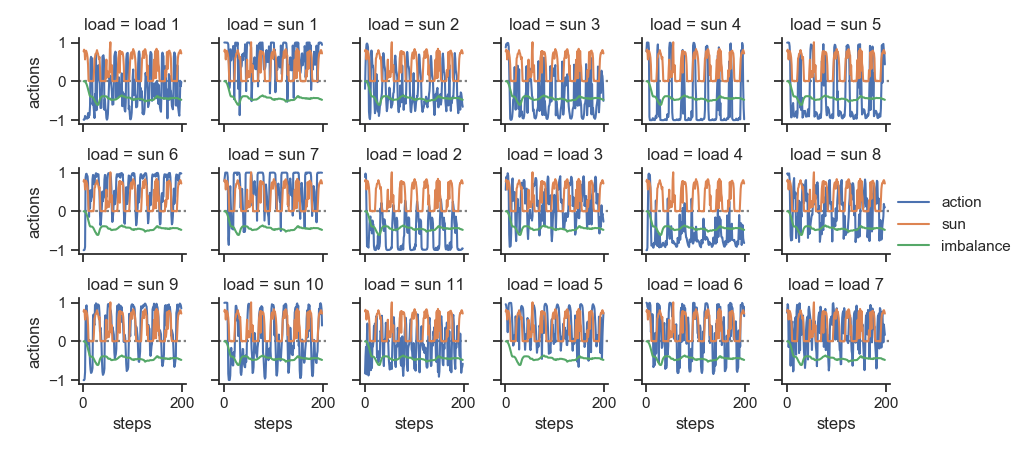

In [6]:
df = simulate_day2(env,model, show_imbalance=True, period=199)
#df = df[df['load'].isin(['load 1', 'sun 1'])]
sns.set(style="ticks")

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="load", hue="",
                     col_wrap=6, height=1.5)
#grid = sns.FacetGrid(df, col="load", hue="")


# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")

grid.map(plt.plot, "steps", "actions")
grid.add_legend()



In [99]:
#grid.savefig('figs/configuration1.png')

## Plot individual subplot

In [7]:
def data_from_subplot(ax, imbalance=False):
    actions = ax.lines[3].get_ydata()
    sun = ax.lines[4].get_ydata()
    balance = ax.lines[5].get_ydata() * 30
    oneplot = pd.DataFrame()
    if imbalance:
        oneplot['Energy imbalance'] = balance
    oneplot['Solar irradiance'] = sun
    oneplot['Action'] = actions
    return oneplot

In [8]:
@interact
def plot_load(ax_nr1=range(18),ax_nr2=range(18),period=(0,200)):
    plot1 = data_from_subplot(grid.axes[ax_nr1])
    plot2 = data_from_subplot(grid.axes[ax_nr2])

    fig, axes = plt.subplots(2)
    #axes.set_title(ax.get_title())
    #axes.set_title('Total energy imbalance')
    axes[0].set_xlabel('steps')
    axes[0].axhline(0,c=".5",ls='--')
    axes[1].axhline(0,c=".5",ls='--')
    #axes.set_ylabel('MWh')
    plot1[:period].plot(ax=axes[0])
    plot2[:period].plot(ax=axes[1])
    plt.tight_layout()


interactive(children=(Dropdown(description='ax_nr1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

In [348]:
interact(f,[1,3,4])

TypeError: __call__() takes from 1 to 2 positional arguments but 3 were given

In [228]:
#fig.savefig('figs/configuration1_imbalance.png')

<IPython.core.display.Javascript object>


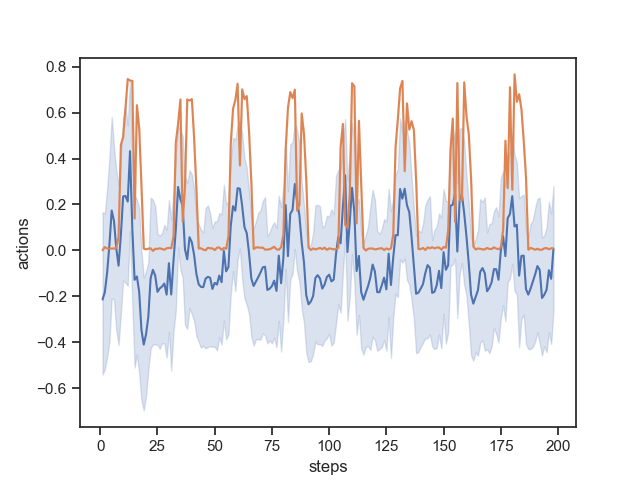

In [401]:
fig,ax = plt.subplots()
sns.lineplot(x="steps", y="actions", data=df[df[''] == 'action'], ax=ax)
sns.lineplot(x="steps", y="actions", data=df[df[''] == 'sun'], ax=ax)


<IPython.core.display.Javascript object>


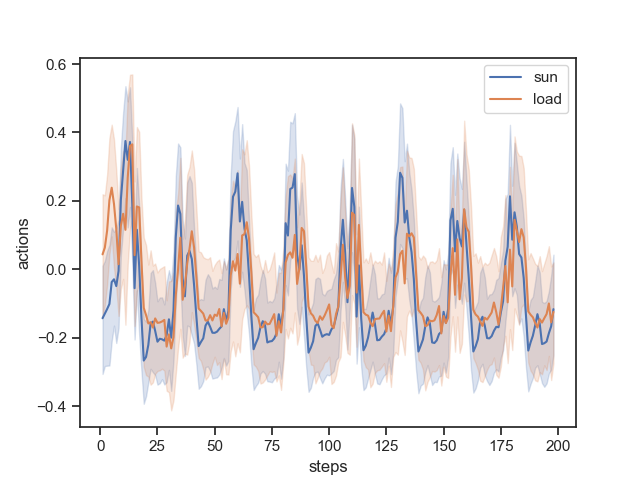

In [421]:
fig,ax = plt.subplots()
sun_data = df[df['load'].apply(lambda x: 'sun' in x)]
load_data = df[df['load'].apply(lambda x: 'load' in x)]
sns.lineplot(x="steps", y="actions", data=sun_data, ax=ax, label='sun')
sns.lineplot(x="steps", y="actions", data=load_data, ax=ax, label='load')



## Import models

In [23]:
model_name = 'activation_cost1'
params = model_name +'_params.pkl'
model = DDPG.load('models/'+model_name)
env = ActiveEnv(force_commitments=False)
model.set_env(env)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

<IPython.core.display.Javascript object>


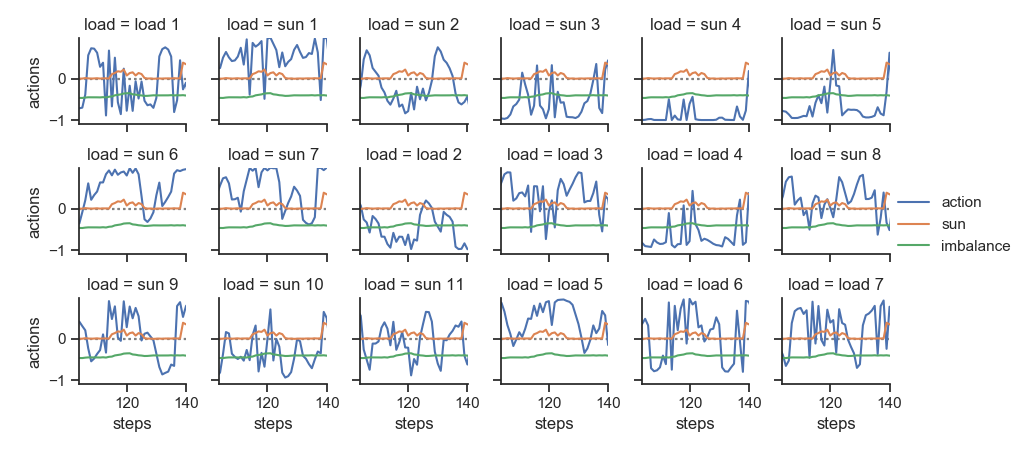

In [21]:
df = simulate_day2(env,model, show_imbalance=True, period=199)
#df = df[df['load'].isin(['load 1', 'sun 1'])]
sns.set(style="ticks")

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="load", hue="",
                     col_wrap=6, height=1.5)
#grid = sns.FacetGrid(df, col="load", hue="")


# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")

grid.map(plt.plot, "steps", "actions")
grid.add_legend()



In [25]:
@interact
def plot_load(ax_nr1=range(18),ax_nr2=range(18),period=(0,200)):
    plot1 = data_from_subplot(grid.axes[ax_nr1],imbalance=False)
    plot2 = data_from_subplot(grid.axes[ax_nr2],imbalance=False)

    fig, axes = plt.subplots(2)
    #axes.set_title(ax.get_title())
    #axes.set_title('Total energy imbalance')
    axes[0].set_xlabel('steps')
    axes[0].axhline(0,c=".5",ls='--')
    axes[1].axhline(0,c=".5",ls='--')
    #axes.set_ylabel('MWh')
    plot1[:period].plot(ax=axes[0])
    plot2[:period].plot(ax=axes[1])
    plt.tight_layout()


interactive(children=(Dropdown(description='ax_nr1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

## See resulting voltages etc

In [22]:
period=199
show_action = True
net = env.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env.reset()
sol = env.get_episode_solar_forecast()
hues = []
env2 = copy.deepcopy(env)
env2.do_action = False

for t_step in range(1,period):

    action,_ = model.predict(obs)
    obs1, rewards1, dones1, info1 = env.step(action)
    obs2, rewards2, dones2, info2 = env2.step(action)
    
    
    v_agent = env.powergrid.res_bus.vm_pu
    actions += list(v_agent)
    hues += ['Agent' for _ in range(len(v_agent))]
    t_steps += list(t_step*np.ones_like(v_agent))
    flex_loads += list(range(len(v_agent)))
    
    
    v_no_action = env2.powergrid.res_bus.vm_pu
    actions += list(v_no_action)
    hues += ['No agent' for _ in range(len(v_no_action))]
    t_steps += list(t_step*np.ones_like(v_no_action))
    flex_loads += list(range(len(v_agent)))

df = pd.DataFrame()
df['actions'] = actions
df['steps'] = t_steps
df['load'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


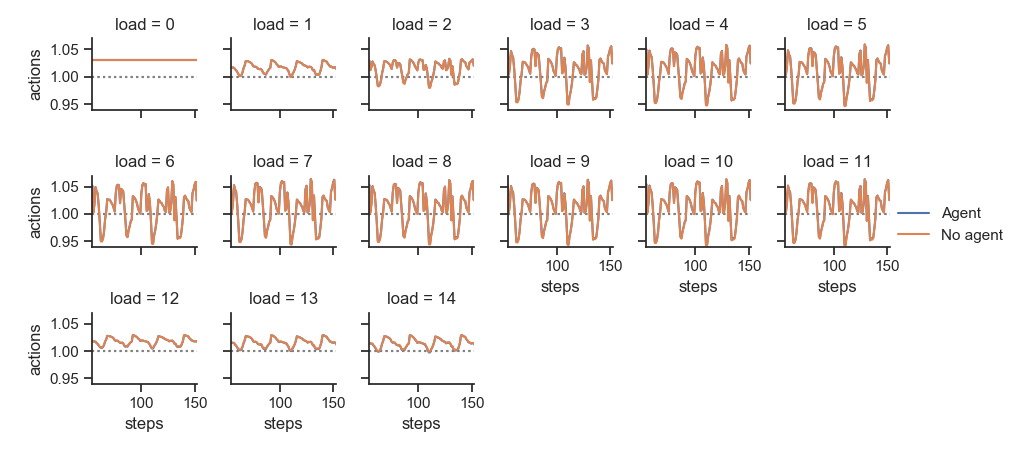

In [17]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="load", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "steps", "actions")
grid.add_legend()



In [18]:
@interact
def plot_voltage(bus_nr=list(range(15))[::-1]):
    data = df[df['load']== bus_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="steps", y="actions", data=data, ax=ax, hue='')
    


interactive(children=(Dropdown(description='bus_nr', options=(14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0…

In [19]:
diff = df[df[''] == 'No agent']['actions'].values - df[df[''] == 'Agent']['actions'].values 
diff.max()

0.0011724464914637522

## Line capacity effect

In [37]:
period=199
show_action = True
net = env.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env.reset()
hues = []
env2 = copy.deepcopy(env)
env2.do_action = False

for t_step in range(1,period):

    action,_ = model.predict(obs)
    obs1, rewards1, dones1, info1 = env.step(action)
    obs2, rewards2, dones2, info2 = env2.step(action)
    
    
    i_agent = env.powergrid.res_line['loading_percent']
    actions += list(i_agent)
    hues += ['Agent' for _ in range(len(i_agent))]
    t_steps += list(t_step*np.ones_like(i_agent))
    flex_loads += list(range(len(i_agent)))
    
    
    i_no_agent = env2.powergrid.res_line['loading_percent']
    actions += list(i_no_agent)
    hues += ['No agent' for _ in range(len(i_no_agent))]
    t_steps += list(t_step*np.ones_like(i_no_agent))
    flex_loads += list(range(len(i_no_agent)))

df = pd.DataFrame()
df['actions'] = actions
df['steps'] = t_steps
df['line'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


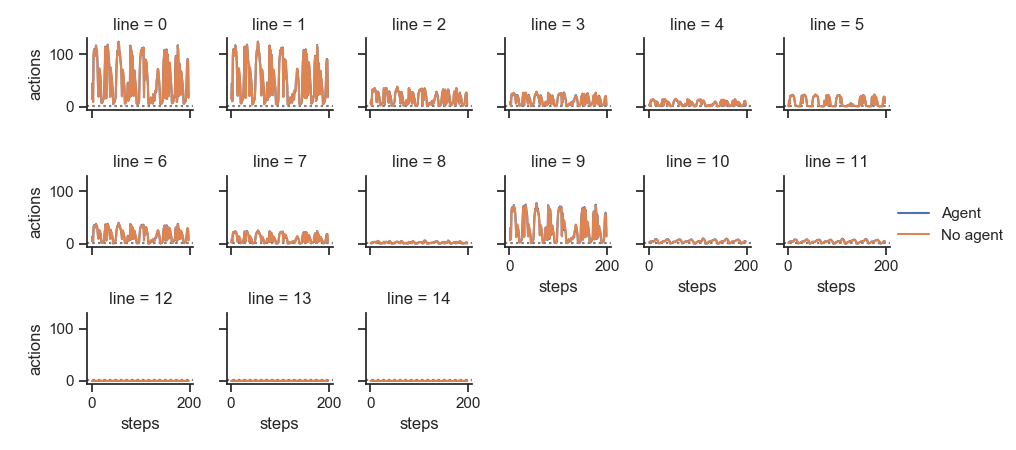

In [38]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="line", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "steps", "actions")
grid.add_legend()



In [39]:
@interact
def plot_current(bus_nr=list(range(15))[::-1]):
    data = df[df['line']== bus_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="steps", y="actions", data=data, ax=ax, hue='')
    


interactive(children=(Dropdown(description='bus_nr', options=(14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0…